# Titanic and Bank Marketing Data Analysis

## Import Libraries

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from icecream import ic

## Fonctions utiles 

In [18]:
def read_data(filename):
    data = []
    try:
        data = pd.read_csv(filename)
        print("Data loaded")
    except Exception as e:
        print (f"Exception raised: {e}")
    return data

## Remplacement des valeur manquante par la mediane ##
def replace_null_by_mean(df, colonne):
    df[colonne] = df[colonne].fillna(df[colonne].median()).astype(int)
    return df 

## Normaliser les valeurs categorielles ##
def normalize_non_numeric_values(df, colonne):
    data = []
    data = pd.get_dummies(df, columns=[colonne])
    return data 

## Visualiser les données ##
def visualize_data(data, color, title, x_name, y_name):
    #plt.figure(figsize=(6,5))
    data.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.xticks(rotation=0)
    plt.show()

## Remplacer les valeurs null par le mode
def replace_with_mode (df):
    data = []
    non_numeric_cols = df.select_dtypes(exclude=['number']).columns
    for col in non_numeric_cols:
        df.loc[:, col] = df[col].fillna(df[col].mode()[0]) 
    return df

## Modelisation des classificateurs 
def train_classifier(models, folds, X_train, X_test, y_train, y_test):
    results = []
    df_results = []
    
    for name, model in models.items():
        print(f"\n🔍 Modèle : {name}")

        for k in folds:
            print(f"  ▶ Cross-validation {k}-folds...")
    
            # Cross-validation pour évaluer la robustesse
            accuracy = cross_val_score(model, X_train, y_train, cv=k, scoring='accuracy').mean() * 100
            precision = cross_val_score(model, X_train, y_train, cv=k, scoring='precision').mean() * 100
            recall = cross_val_score(model, X_train, y_train, cv=k, scoring='recall').mean() * 100
            f1 = cross_val_score(model, X_train, y_train, cv=k, scoring='f1').mean() * 100
    
            # Entraîner le modèle sur le dataset complet et évaluer sur le test set
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
            # Calcul des métriques sur le test set
            test_accuracy = accuracy_score(y_test, y_pred) * 100
            test_precision = precision_score(y_test, y_pred) * 100
            test_recall = recall_score(y_test, y_pred) * 100
            test_f1 = f1_score(y_test, y_pred) * 100
            test_auc = roc_auc_score(y_test, y_proba) * 100 if y_proba is not None else np.nan
    
            results.append([name, k, accuracy, precision, recall, f1, test_accuracy, test_precision, test_recall, test_f1, test_auc])
            
    # Convertir les résultats en DataFrame
    df_results = pd.DataFrame(results, columns=["Modèle", "Folds", "CV_Accuracy", "CV_Precision", "CV_Recall", "CV_F1", "Test_Accuracy", "Test_Precision", "Test_Recall", "Test_F1", "Test_AUC"])
    return df_results

## Import Datasets Titanic

In [21]:
filename_titanic = './Jeux de données Titanic/train.csv'
filename_titanic_test = './Jeux de données Titanic/test.csv'
titanic_train_data = read_data(filename_titanic)
titanic_test_data = read_data(filename_titanic_test)

Data loaded
Data loaded


## Import Dataset Bank Marketing

In [61]:
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# metadata 
# print(bank_marketing.metadata) 
  
# variable information 
print(bank_marketing.variables) 
bank_data = pd.concat([X, y], axis=1)
bank_orignal = pd.concat([X, y], axis=1)

           name     role         type      demographic  \
0           age  Feature      Integer              Age   
1           job  Feature  Categorical       Occupation   
2       marital  Feature  Categorical   Marital Status   
3     education  Feature  Categorical  Education Level   
4       default  Feature       Binary             None   
5       balance  Feature      Integer             None   
6       housing  Feature       Binary             None   
7          loan  Feature       Binary             None   
8       contact  Feature  Categorical             None   
9   day_of_week  Feature         Date             None   
10        month  Feature         Date             None   
11     duration  Feature      Integer             None   
12     campaign  Feature      Integer             None   
13        pdays  Feature      Integer             None   
14     previous  Feature      Integer             None   
15     poutcome  Feature  Categorical             None   
16            

## Peek at data 

In [29]:
print('\n------------- Titanic train data --------------\n')
titanic_train_data.info()
print('\n------------- Titanic test data --------------\n')
titanic_test_data.info()
print('\n------------- Bank Marketing data --------------\n')
bank_data.info()


------------- Titanic train data --------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

------------- Titanic test data --------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 

## Nettoyage de données dataset titanic train 

In [65]:
## remplacement des valeurs null de l'age par la moyenne ##
data_titanic_train_clean = replace_null_by_mean(titanic_train_data, 'Age') ### prendre la mediane 
data_titanic_train_clean = normalize_non_numeric_values(data_titanic_train_clean, 'Sex')
data_titanic_train_clean = normalize_non_numeric_values(data_titanic_train_clean, 'Embarked')
data_titanic_train_clean.fillna("Inconnu", inplace=True)
print('\n------------- Titanic train data --------------\n')
data_titanic_train_clean.info()
duplicate_rows = data_titanic_train_clean[data_titanic_train_clean.duplicated()]
print(f"Nombre de lignes dupliquées : {duplicate_rows.shape[0]}")


------------- Titanic train data --------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Age          891 non-null    int32  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    object 
 10  Sex_female   891 non-null    bool   
 11  Sex_male     891 non-null    bool   
 12  Embarked_C   891 non-null    bool   
 13  Embarked_Q   891 non-null    bool   
 14  Embarked_S   891 non-null    bool   
dtypes: bool(5), float64(1), int32(1), int64(5), object(3)
memory usage: 70.6+ KB
Nombre de lignes dupliquées : 0


## Nettoyage de données dataset titanic test

In [79]:
data_titanic_test_clean = replace_null_by_mean(titanic_test_data, 'Age')
data_titanic_test_clean = replace_null_by_mean(data_titanic_test_clean, 'Fare')
data_titanic_test_clean = normalize_non_numeric_values(data_titanic_test_clean, 'Sex')
data_titanic_test_clean = normalize_non_numeric_values(data_titanic_test_clean, 'Embarked')
data_titanic_test_clean.fillna("Inconnu", inplace=True)
print('\n------------- Titanic test data --------------\n')
data_titanic_test_clean.info()


------------- Titanic test data --------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  418 non-null    int64 
 1   Pclass       418 non-null    int64 
 2   Name         418 non-null    object
 3   Age          418 non-null    int32 
 4   SibSp        418 non-null    int64 
 5   Parch        418 non-null    int64 
 6   Ticket       418 non-null    object
 7   Fare         418 non-null    int32 
 8   Cabin        418 non-null    object
 9   Sex_female   418 non-null    bool  
 10  Sex_male     418 non-null    bool  
 11  Embarked_C   418 non-null    bool  
 12  Embarked_Q   418 non-null    bool  
 13  Embarked_S   418 non-null    bool  
dtypes: bool(5), int32(2), int64(4), object(3)
memory usage: 28.3+ KB


## Nettoyage de données de Bank 

In [68]:
bank_data_clean = replace_with_mode(bank_data)
bank_data_clean.replace({"no": False, "yes": True}, inplace=True)
duplicate_rows = bank_data_clean[bank_data_clean.duplicated()]
print('\n------------- Bank Marketing data sans imputation --------------\n')
bank_data_clean.info()
print(f"Nombre de lignes dupliquées : {duplicate_rows.shape[0]}")


------------- Bank Marketing data sans imputation --------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          45211 non-null  object
 2   marital      45211 non-null  object
 3   education    45211 non-null  object
 4   default      45211 non-null  bool  
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  bool  
 7   loan         45211 non-null  bool  
 8   contact      45211 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     45211 non-null  object
 16  y            45211 non-null  bool  
dtypes: bool(4), int64(7), object(6)
memory u

C:\Users\djeut\AppData\Local\Temp\ipykernel_45780\1246011842.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bank_data_clean.replace({"no": False, "yes": True}, inplace=True)


## Statitisques descriptives de data titanic train 

In [71]:
# la stat descriptive se fait que les colonnes numeriques 
print('\n------------- Titanic train data --------------\n')
data_titanic_train_clean.describe().round(3)


------------- Titanic train data --------------



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,891.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.346,0.523,0.382,32.204
std,257.354,0.487,0.836,13.028,1.103,0.806,49.693
min,1.000,0.000,1.000,0.000,0.000,0.000,0.000
25%,223.500,0.000,2.000,22.000,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,35.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


## Statistiques descriptives de data titanic test 

In [74]:
print('\n------------- Titanic train data --------------\n')
data_titanic_train_clean.describe().round(3)


------------- Titanic train data --------------



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,891.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.346,0.523,0.382,32.204
std,257.354,0.487,0.836,13.028,1.103,0.806,49.693
min,1.000,0.000,1.000,0.000,0.000,0.000,0.000
25%,223.500,0.000,2.000,22.000,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,35.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [76]:
###visualisation des toutes les colonnes
print('\n------------- Titanic train data --------------\n')
data_titanic_train_clean.describe(include='all')


------------- Titanic train data --------------



,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891,891.000000,891.000000,891.000000,891,891.000000,891,891,891,891,891,891
unique,NaN,NaN,NaN,891,NaN,NaN,NaN,681,NaN,148,2,2,2,2,2
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",NaN,NaN,NaN,347082,NaN,Inconnu,False,True,False,False,True
freq,NaN,NaN,NaN,1,NaN,NaN,NaN,7,NaN,687,577,577,723,814,644
mean,446.000000,0.383838,2.308642,NaN,29.345679,0.523008,0.381594,NaN,32.204208,NaN,NaN,NaN,NaN,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,13.028212,1.102743,0.806057,NaN,49.693429,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,22.000000,0.000000,0.000000,NaN,7.910400,NaN,NaN,NaN,NaN,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN,NaN,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,35.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
print('\n------------- Titanic test data --------------\n')
data_titanic_test_clean.describe(include='all')


------------- Titanic test data --------------



,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,418.000000,418.000000,418,418.000000,418.000000,418.000000,418,418.000000,418,418,418,418,418,418
unique,NaN,NaN,418,NaN,NaN,NaN,363,NaN,77,2,2,2,2,2
top,NaN,NaN,"Kelly, Mr. James",NaN,NaN,NaN,PC 17608,NaN,Inconnu,False,True,False,False,True
freq,NaN,NaN,1,NaN,NaN,NaN,5,NaN,327,266,266,316,372,270
mean,1100.500000,2.265550,NaN,29.574163,0.447368,0.392344,NaN,35.133971,NaN,NaN,NaN,NaN,NaN,NaN
std,120.810458,0.841838,NaN,12.721533,0.896760,0.981429,NaN,55.855855,NaN,NaN,NaN,NaN,NaN,NaN
min,892.000000,1.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,996.250000,1.000000,NaN,23.000000,0.000000,0.000000,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1100.500000,3.000000,NaN,27.000000,0.000000,0.000000,NaN,14.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,1204.750000,3.000000,NaN,35.750000,1.000000,0.000000,NaN,31.000000,NaN,NaN,NaN,NaN,NaN,NaN


## Statitisques descriptives de Dataset Bank 

In [44]:
print('\n------------- Bank Marketing data --------------\n')
bank_data_clean.describe(include='all')


------------- Bank Marketing data --------------



,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,11,3,3,2,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,3,2
top,NaN,blue-collar,married,secondary,False,NaN,True,False,cellular,NaN,may,NaN,NaN,NaN,NaN,failure,False
freq,NaN,10020,27214,25059,44396,NaN,25130,37967,42305,NaN,13766,NaN,NaN,NaN,NaN,41860,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


## Observation des données de titanic train 

In [83]:
### nombre de survivants
survive_distr = data_titanic_train_clean.groupby('Survived').size()
survive_distr

Survived
0    549
1    342
dtype: int64

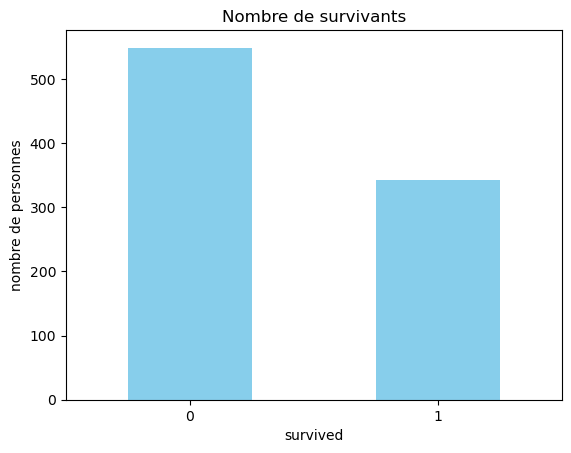

In [85]:
## Plot survived 
visualize_data(survive_distr, 'skyblue', 'Nombre de survivants', 'survived', 'nombre de personnes')

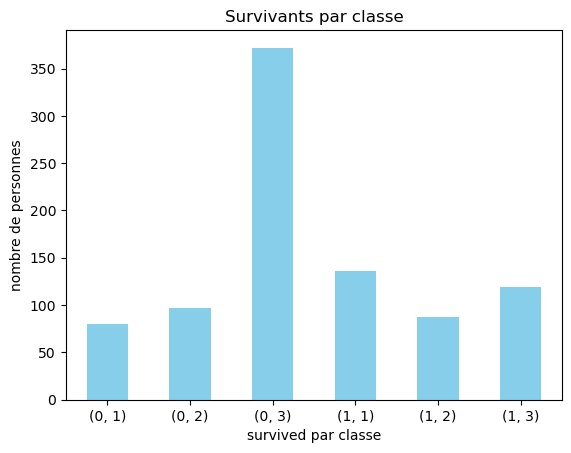

In [87]:
### surivants par classe ###
class_counts = data_titanic_train_clean.groupby(['Survived', 'Pclass']).size()
visualize_data(class_counts, 'skyblue', 'Survivants par classe', 'survived par classe', 'nombre de personnes')

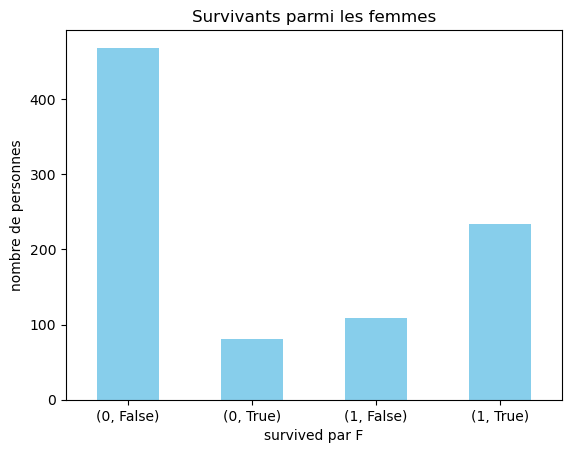

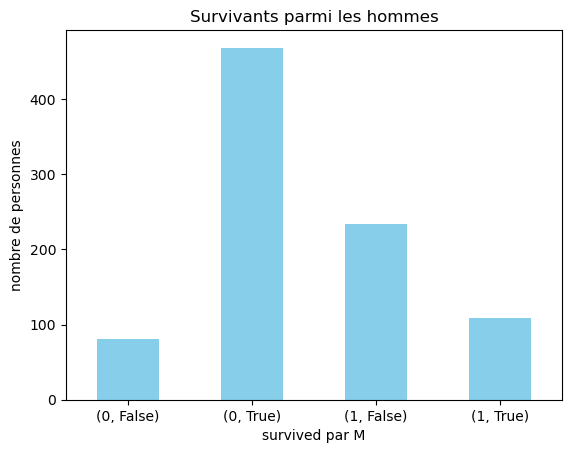

In [89]:
## Survivant par genre ##
male_counts = data_titanic_train_clean.groupby(['Survived', 'Sex_male']).size()
female_counts = data_titanic_train_clean.groupby(['Survived', 'Sex_female']).size()
visualize_data(female_counts, 'skyblue', 'Survivants parmi les femmes', 'survived par F', 'nombre de personnes')
visualize_data(male_counts, 'skyblue', 'Survivants parmi les hommes', 'survived par M' , 'nombre de personnes')

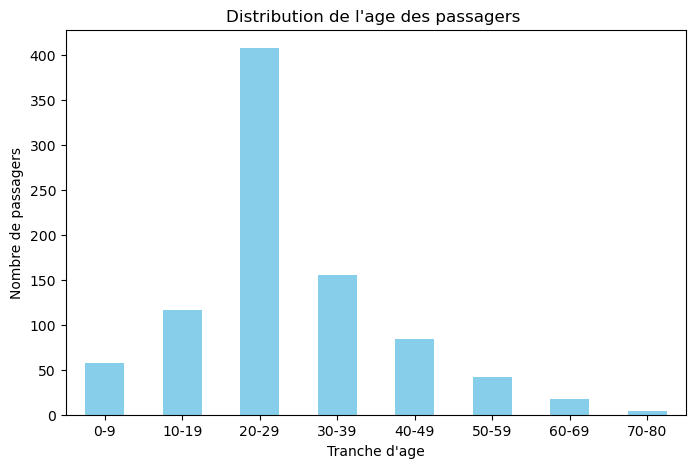

In [91]:
titanic_encoded = data_titanic_train_clean
# plot
# Définir les tranches d'âge (bins)
bins = range(0, 81, 10)
#labels = [f"{i}-{i+9}" for i in bins[:-1]]  # Ex: "0-9", "10-19", etc.
labels = [f"{i}-{i+9}" for i in bins[:-2]] + ["70-80"]

# Grouper les âges dans des intervalles
titanic_encoded["AgeGroup"] = pd.cut(titanic_encoded["Age"], bins=bins, labels=labels, right=True)

# Compter le nombre de passagers par tranche d'âge
age_counts = titanic_encoded["AgeGroup"].value_counts().sort_index()

plt.figure(figsize=(8,5))
age_counts.plot(kind="bar", color="skyblue")
plt.title("Distribution de l'age des passagers ")
plt.xlabel("Tranche d'age")
plt.ylabel("Nombre de passagers")
plt.xticks(rotation=0)
plt.show()

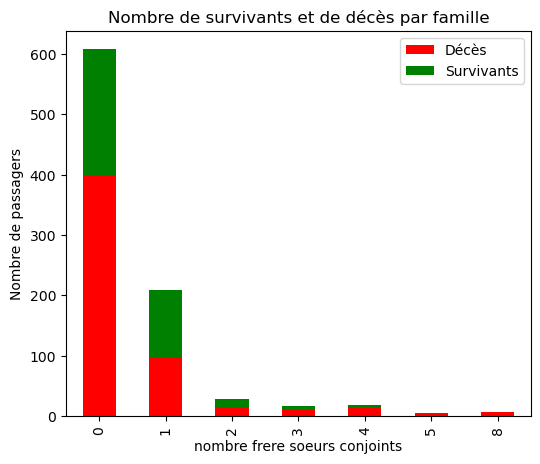

In [93]:
### Survivants par famille ###
sibling_spouse_counts = data_titanic_train_clean.groupby(['SibSp', 'Survived']).size().unstack()
sibling_spouse_counts.columns = ['Décès', 'Survivants']
sibling_spouse_counts.plot(kind='bar', stacked=True, figsize=(6, 5), color=['red', 'green'])
plt.xlabel("nombre frere soeurs conjoints")
plt.ylabel("Nombre de passagers")
plt.title("Nombre de survivants et de décès par famille")
plt.legend(["Décès", "Survivants"])
plt.show()

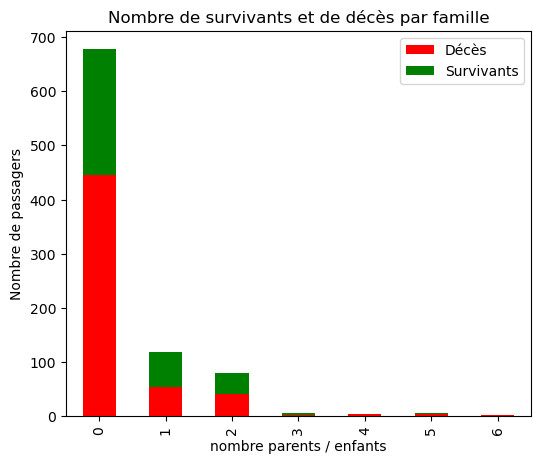

In [95]:
parents_kids_counts = data_titanic_train_clean.groupby(['Parch', 'Survived']).size().unstack()
parents_kids_counts.columns = ['Décès', 'Survivants']
parents_kids_counts.plot(kind='bar', stacked=True, figsize=(6, 5), color=['red', 'green'])
plt.xlabel("nombre parents / enfants")
plt.ylabel("Nombre de passagers")
plt.title("Nombre de survivants et de décès par famille")
plt.legend(["Décès", "Survivants"])
plt.show()

## Matrice de corrélation pour les variables numériques

In [ ]:
titanic_encoded = data_titanic_train_clean
#Sélection des deux variables numériques à analyser
vars_numeriques = ['Fare', 'Pclass']

# Calcul de la matrice de corrélation
corr_matrix = titanic_encoded[vars_numeriques].corr(method='spearman')

# Affichage de la heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title(f"Matrice de corrélation entre {vars_numeriques[0]} et {vars_numeriques[1]}")
plt.show()

In [ ]:
# Sélection des deux variables numériques à analyser
vars_numeriques = ['Survived', 'Fare']

# Calcul de la matrice de corrélation
corr_matrix = titanic_encoded[vars_numeriques].corr(method='pearson')

# Affichage de la heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title(f"Matrice de corrélation entre {vars_numeriques[0]} et {vars_numeriques[1]}")
plt.show()

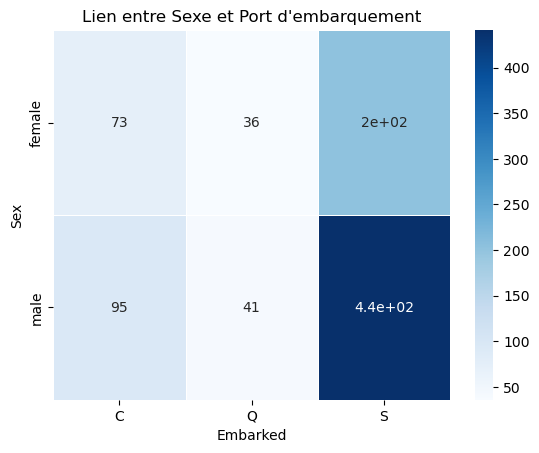

In [98]:
titanic_encoded = titanic_train_data
sns.heatmap(pd.crosstab(titanic_encoded["Sex"], titanic_encoded["Embarked"]), annot=True, cmap="Blues", linewidths=0.5)
plt.title("Lien entre Sexe et Port d'embarquement")
plt.show()

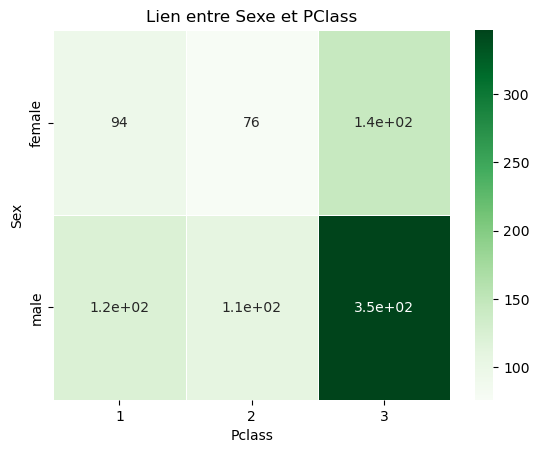

In [100]:
titanic_encoded = titanic_train_data
sns.heatmap(pd.crosstab(titanic_encoded["Sex"], titanic_encoded["Pclass"]), annot=True, cmap="Greens", linewidths=0.5)
plt.title("Lien entre Sexe et PClass")
plt.show()

## Observation de données Bank Marketing 

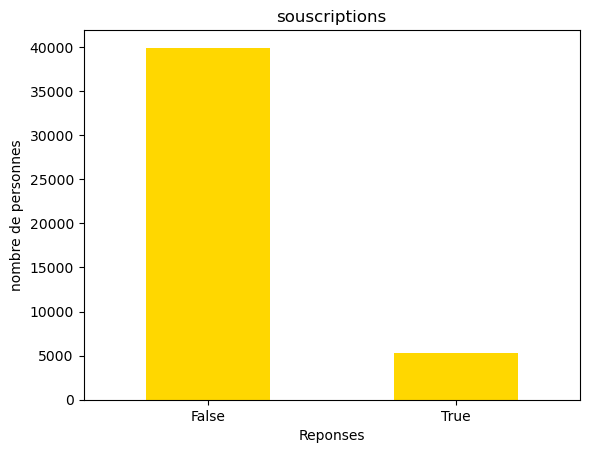

y
False    39922
True      5289
dtype: int64

In [103]:
### nombre de personnes ayant souscrit 
subscription_distr = bank_data_clean.groupby('y').size()
visualize_data(subscription_distr, 'gold', 'souscriptions', 'Reponses', 'nombre de personnes')
subscription_distr

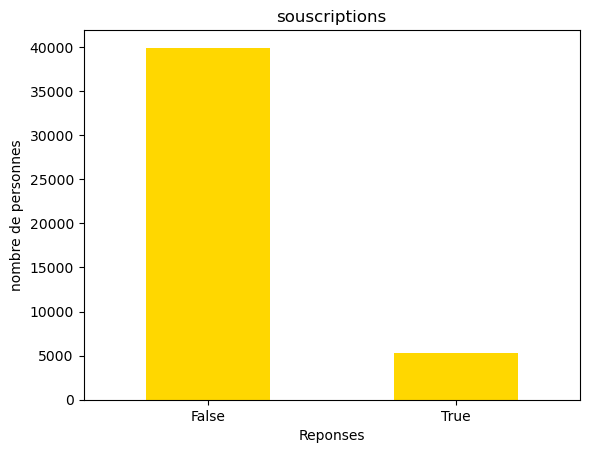

y
False    39922
True      5289
dtype: int64

In [105]:
### nombre de personnes ayant souscrit 
subscription_distr = bank_data_clean.groupby('y').size()
visualize_data(subscription_distr, 'gold', 'souscriptions', 'Reponses', 'nombre de personnes')
subscription_distr

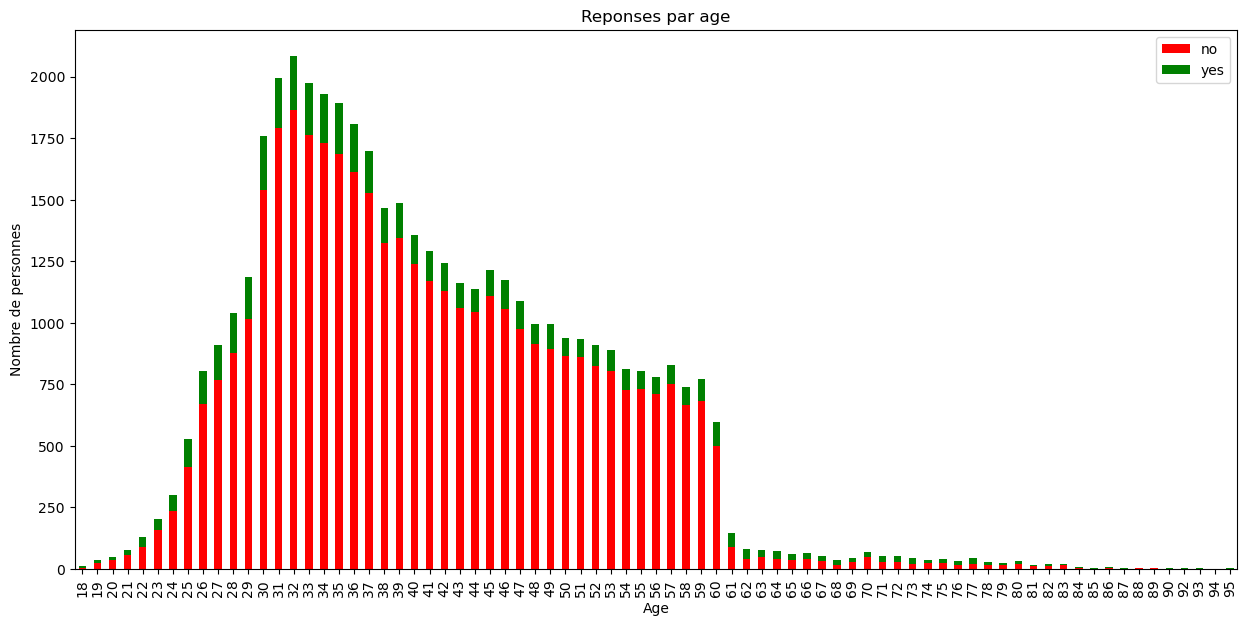

In [107]:
### Souscriptions selon l'age
sub_age_counts = bank_data_clean.groupby(['age', 'y']).size().unstack()
sub_age_counts.columns = ['no', 'yes']
sub_age_counts.plot(kind='bar', stacked=True, figsize=(15, 7), color=['red', 'green'])
plt.xlabel("Age")
plt.ylabel("Nombre de personnes")
plt.title("Reponses par age")
plt.legend(["no", "yes"])
plt.show()
### peu importe l'age, le non domine 

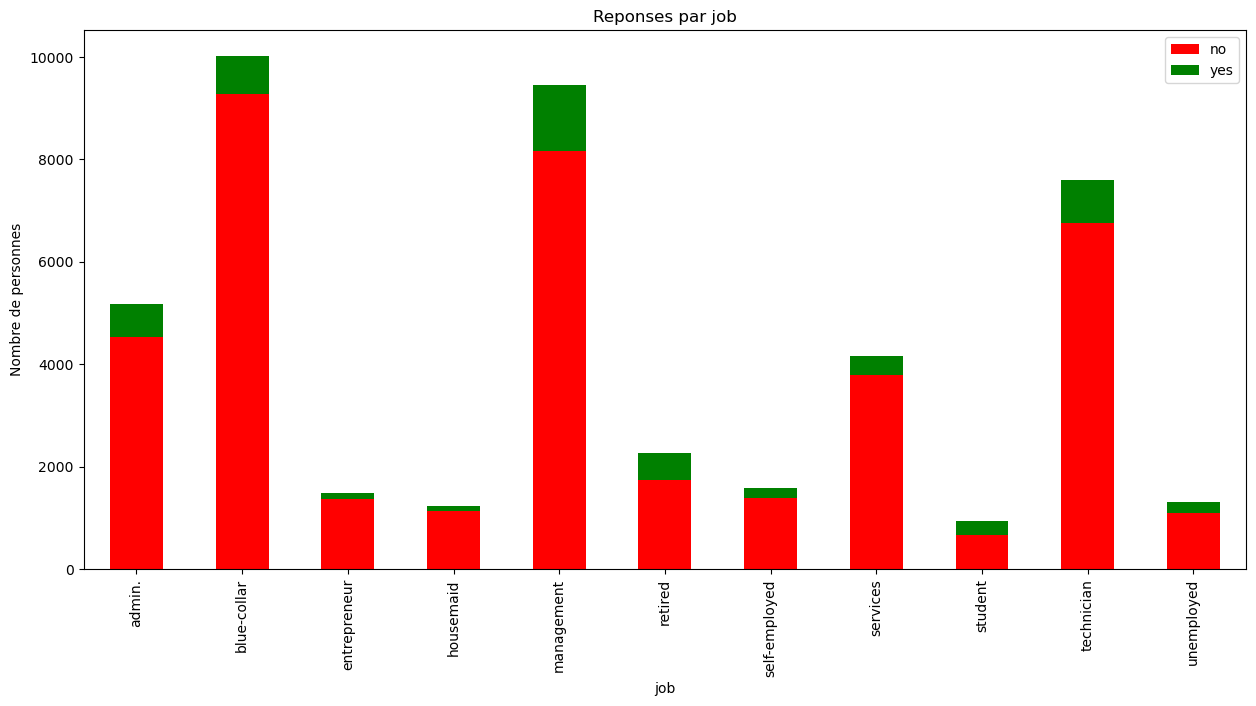

In [109]:
### Souscriptions selon le job
sub_job_counts = bank_data_clean.groupby(['job', 'y']).size().unstack()
sub_job_counts.columns = ['no', 'yes']
sub_job_counts.plot(kind='bar', stacked=True, figsize=(15, 7), color=['red', 'green'])
plt.xlabel("job")
plt.ylabel("Nombre de personnes")
plt.title("Reponses par job")
plt.legend(["no", "yes"])
plt.show()

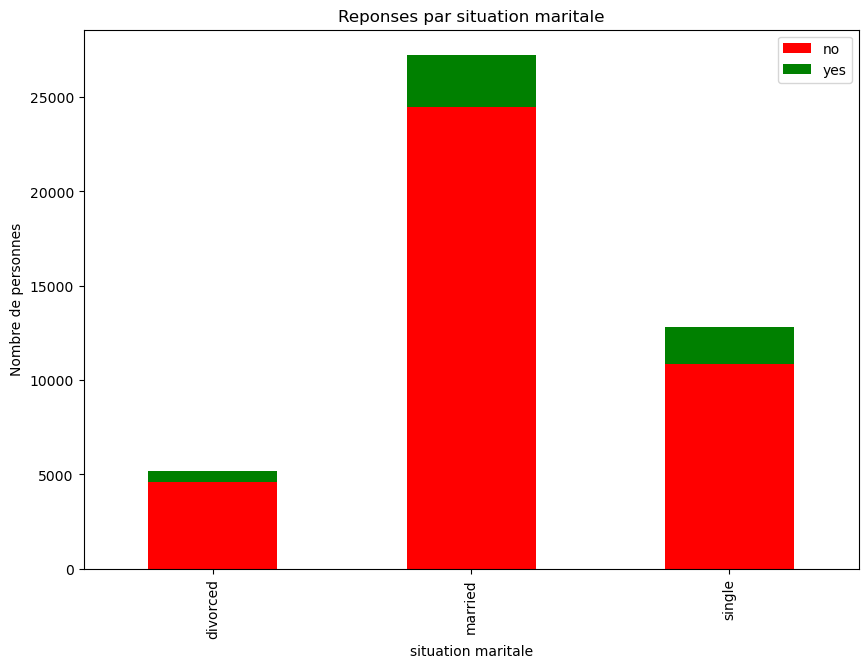

,no,yes
marital,,
divorced,4585,622
married,24459,2755
single,10878,1912


In [111]:
### Souscriptions selon le statut maritale
sub_marital_counts = bank_data_clean.groupby(['marital', 'y']).size().unstack()
sub_marital_counts.columns = ['no', 'yes']
sub_marital_counts.plot(kind='bar', stacked=True, figsize=(10, 7), color=['red', 'green'])
plt.xlabel("situation maritale")
plt.ylabel("Nombre de personnes")
plt.title("Reponses par situation maritale")
plt.legend(["no", "yes"])
plt.show()
sub_marital_counts

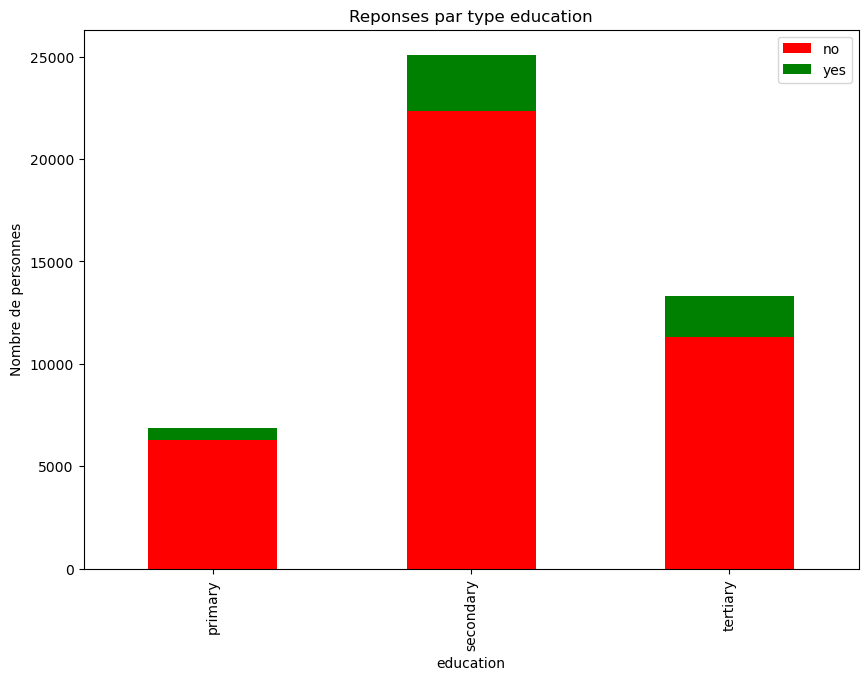

,no,yes
education,,
primary,6260,591
secondary,22357,2702
tertiary,11305,1996


In [113]:
### Souscriptions selon l'education
sub_edu_counts = bank_data_clean.groupby(['education', 'y']).size().unstack()
sub_edu_counts.columns = ['no', 'yes']
sub_edu_counts.plot(kind='bar', stacked=True, figsize=(10, 7), color=['red', 'green'])
plt.xlabel("education")
plt.ylabel("Nombre de personnes")
plt.title("Reponses par type education")
plt.legend(["no", "yes"])
plt.show()
sub_edu_counts

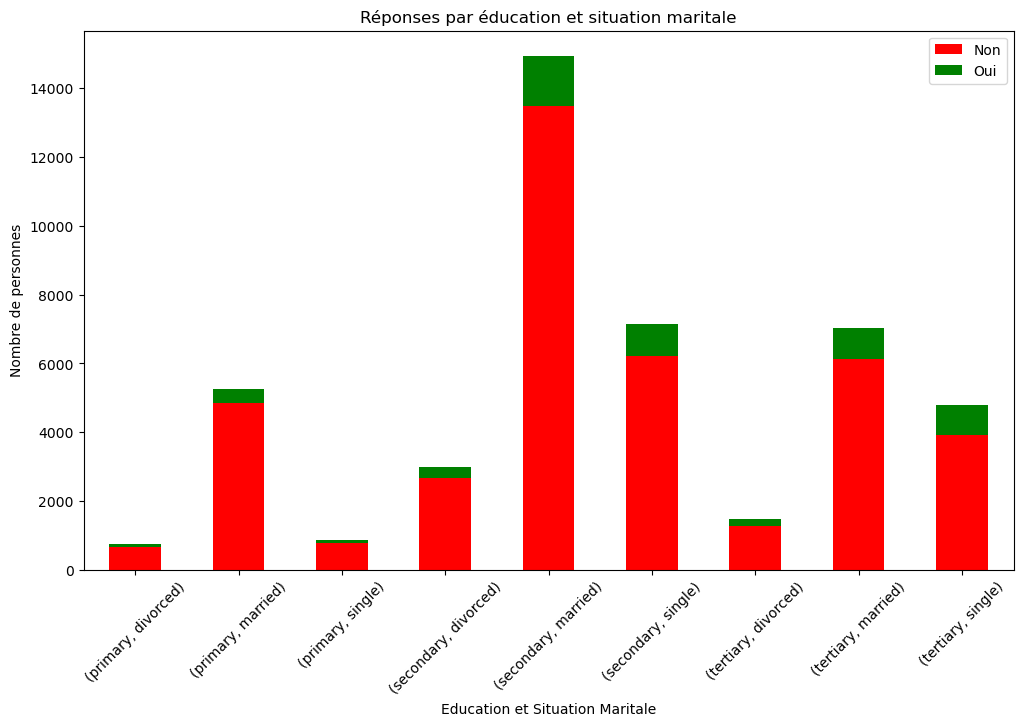

no   yes
education marital              
primary   divorced    648   104
          married    4850   396
          single      762    91
secondary divorced   2669   315
          married   13484  1446
          single     6204   941
tertiary  divorced   1268   203
          married    6125   913
          single     3912   880

In [115]:
## Souscription par rapport à l'education et la situation maritale 
edu_marital_counts = pd.crosstab([bank_data_clean["education"], bank_data_clean["marital"]], bank_data_clean["y"])
edu_marital_counts.columns = ['no', 'yes']
edu_marital_counts.plot(kind='bar', stacked=True, figsize=(12, 7), color=['red', 'green'])
plt.xlabel("Education et Situation Maritale")
plt.ylabel("Nombre de personnes")
plt.title("Réponses par éducation et situation maritale")
plt.legend(["Non", "Oui"])
plt.xticks(rotation=45)  
plt.show()
edu_marital_counts

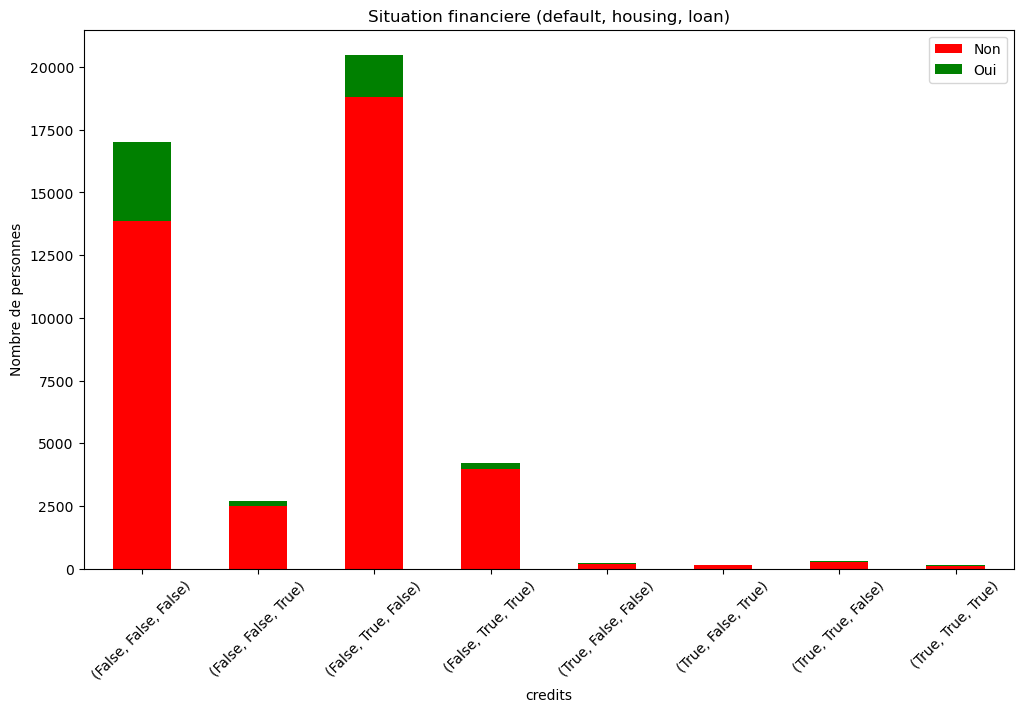

no   yes
default housing loan              
False   False   False  13872  3120
                True    2498   211
        True    False  18813  1648
                True    3976   258
True    False   False    197    15
                True     160     8
        True    False    280    22
                True     126     7

In [117]:
## Souscription selon les dettes 
debt_counts = pd.crosstab([bank_data_clean["default"], bank_data_clean["housing"],  bank_data_clean["loan"]], bank_data_clean["y"])
debt_counts.columns = ['no', 'yes']
debt_counts.plot(kind='bar', stacked=True, figsize=(12, 7), color=['red', 'green'])
plt.xlabel("credits")
plt.ylabel("Nombre de personnes")
plt.title("Situation financiere (default, housing, loan)")
plt.legend(["Non", "Oui"])
plt.xticks(rotation=45)  
plt.show()
debt_counts

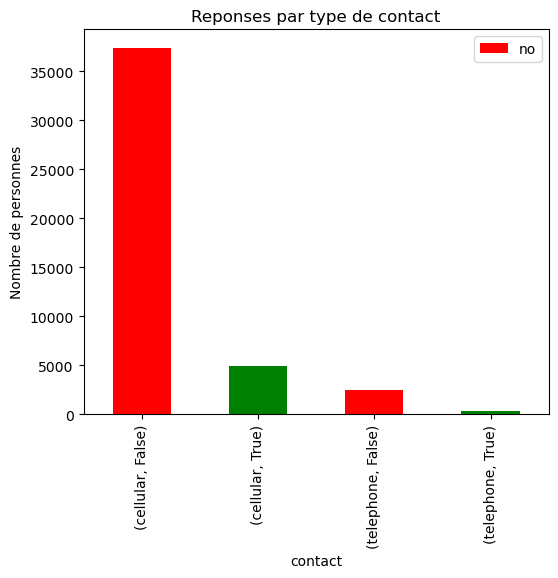

contact    y    
cellular   False    37406
           True      4899
telephone  False     2516
           True       390
dtype: int64

In [119]:
### Souscription selon le type de contact 
contact_counts = bank_data_clean.groupby(['contact', 'y']).size()
contact_counts.columns = ['no', 'yes']
contact_counts.plot(kind='bar', stacked=True, figsize=(6, 5), color=['red', 'green'])
plt.xlabel("contact")
plt.ylabel("Nombre de personnes")
plt.title("Reponses par type de contact")
plt.legend(["no", "yes"])
plt.show()
contact_counts

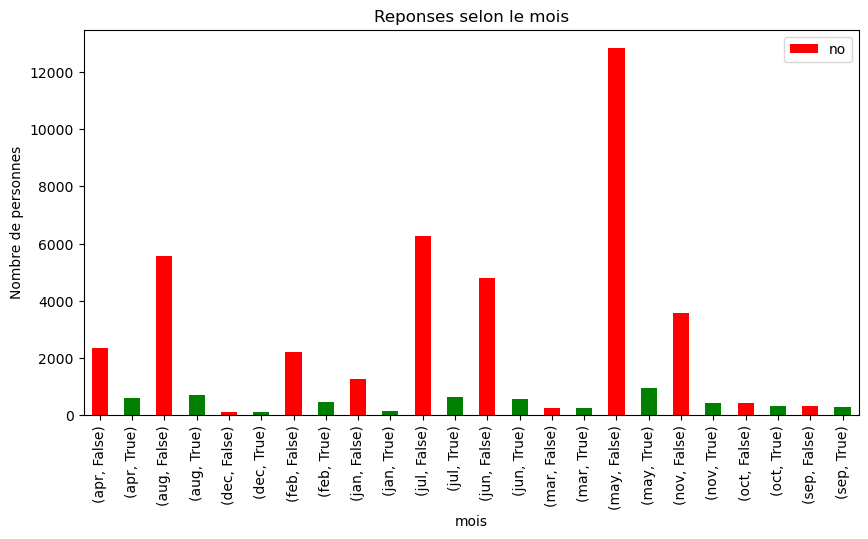

month  y    
apr    False     2355
       True       577
aug    False     5559
       True       688
dec    False      114
       True       100
feb    False     2208
       True       441
jan    False     1261
       True       142
jul    False     6268
       True       627
jun    False     4795
       True       546
mar    False      229
       True       248
may    False    12841
       True       925
nov    False     3567
       True       403
oct    False      415
       True       323
sep    False      310
       True       269
dtype: int64

In [121]:
### Souscription selon le mois de contact
month_counts = bank_data_clean.groupby(['month', 'y']).size()
month_counts.columns = ['no', 'yes']
month_counts.plot(kind='bar', stacked=True, figsize=(10, 5), color=['red', 'green'])
plt.xlabel("mois")
plt.ylabel("Nombre de personnes")
plt.title("Reponses selon le mois")
plt.legend(["no", "yes"])
plt.show()
month_counts

## Matrice de correlation 

In [128]:
corr_matrix = bank_pred.corr() 
plt.figure(figsize=(20,10))  # Taille de la figure
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

NameError: name 'bank_pred' is not defined

## Datasets titanic pour faire la prediction 

In [131]:
titanic_predictions = data_titanic_train_clean.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'AgeGroup'])
pd.set_option('future.no_silent_downcasting', True)
titanic_predictions = titanic_predictions.replace({True: 1, False: 0})
print('\n------------- Titanic prediction data --------------\n')
titanic_predictions.info()
titanic_predictions


------------- Titanic prediction data --------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    int32  
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_female  891 non-null    object 
 7   Sex_male    891 non-null    object 
 8   Embarked_C  891 non-null    object 
 9   Embarked_Q  891 non-null    object 
 10  Embarked_S  891 non-null    object 
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 73.2+ KB


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22,1,0,7.2500,0,1,0,0,1
1,1,1,38,1,0,71.2833,1,0,1,0,0
2,1,3,26,0,0,7.9250,1,0,0,0,1
3,1,1,35,1,0,53.1000,1,0,0,0,1
4,0,3,35,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27,0,0,13.0000,0,1,0,0,1
887,1,1,19,0,0,30.0000,1,0,0,0,1
888,0,3,28,1,2,23.4500,1,0,0,0,1
889,1,1,26,0,0,30.0000,0,1,1,0,0


## Dataset titanic pour test 

In [136]:
titanic_test = data_titanic_test_clean.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
pd.set_option('future.no_silent_downcasting', True)
titanic_test = titanic_test.replace({True: 1, False: 0})
titanic_test.info()
titanic_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Pclass      418 non-null    int64 
 1   Age         418 non-null    int32 
 2   SibSp       418 non-null    int64 
 3   Parch       418 non-null    int64 
 4   Fare        418 non-null    int32 
 5   Sex_female  418 non-null    object
 6   Sex_male    418 non-null    object
 7   Embarked_C  418 non-null    object
 8   Embarked_Q  418 non-null    object
 9   Embarked_S  418 non-null    object
dtypes: int32(2), int64(3), object(5)
memory usage: 29.5+ KB


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34,0,0,7,0,1,0,1,0
1,3,47,1,0,7,1,0,0,0,1
2,2,62,0,0,9,0,1,0,1,0
3,3,27,0,0,8,0,1,0,0,1
4,3,22,1,1,12,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
413,3,27,0,0,8,0,1,0,0,1
414,1,39,0,0,108,1,0,1,0,0
415,3,38,0,0,7,0,1,0,0,1
416,3,27,0,0,8,0,1,0,0,1


## Datasets Marketing pour la prediction

In [142]:
bank_pred = bank_data_clean 
non_numeric_cols = bank_pred.select_dtypes(exclude=['number']).columns

bank_pred = bank_pred.replace({True: 1, False: 0})
bank_pred = bank_pred.replace({'telephone': 1, 'cellular': 0})
bank_pred = bank_pred.replace({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7
                              , 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})

# Identifier les colonnes contenant uniquement 0 et 1
binary_cols = [col for col in bank_pred.columns if bank_pred[col].dropna().isin([0, 1]).all()]

# Convertir ces colonnes en type int
bank_pred[binary_cols] = bank_pred[binary_cols].astype(int)
bank_pred["month"] = bank_pred["month"].astype("int64")

non_numeric_cols = bank_pred.select_dtypes(exclude=['number']).columns
for col in non_numeric_cols :
    if col != 'y':
        bank_pred = normalize_non_numeric_values(bank_pred, col)

bank_pred = bank_pred.replace({True: 1, False: 0})
binary_cols = [col for col in bank_pred.columns if bank_pred[col].dropna().isin([0, 1]).all()]
bank_pred[binary_cols] = bank_pred[binary_cols].astype(int)

### Selection des variables par features importance
X = bank_pred.drop(columns=['y'])  # Variables explicatives
y = bank_pred['y']  # Variable cible
rf = RandomForestClassifier()
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("\n--------feature importance----------\n")
print(importances.sort_values(ascending=False))
print("\n--------Data info----------\n")
bank_pred.info()
bank_pred


--------feature importance----------

duration               0.276081
balance                0.108487
age                    0.102176
day_of_week            0.095052
month                  0.076552
poutcome_success       0.048577
pdays                  0.043348
campaign               0.041157
previous               0.023754
housing                0.022411
poutcome_failure       0.019304
job_technician         0.010087
education_secondary    0.009760
marital_married        0.009494
education_tertiary     0.009352
loan                   0.009313
job_management         0.009265
job_admin.             0.008534
marital_single         0.008120
job_blue-collar        0.007794
contact                0.007711
poutcome_other         0.007245
marital_divorced       0.006717
job_services           0.006076
education_primary      0.006054
job_retired            0.005141
job_student            0.004669
job_self-employed      0.004506
job_unemployed         0.004460
job_entrepreneur       0.003656
j

,age,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,...,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,poutcome_failure,poutcome_other,poutcome_success
0,58,0,2143,1,0,0,5,5,261,1,...,0,0,1,0,0,0,1,1,0,0
1,44,0,29,1,0,0,5,5,151,1,...,0,0,0,1,0,1,0,1,0,0
2,33,0,2,1,1,0,5,5,76,1,...,0,0,1,0,0,1,0,1,0,0
3,47,0,1506,1,0,0,5,5,92,1,...,0,0,1,0,0,1,0,1,0,0
4,33,0,1,0,0,0,5,5,198,1,...,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,0,17,11,977,3,...,0,0,1,0,0,0,1,1,0,0
45207,71,0,1729,0,0,0,17,11,456,2,...,0,1,0,0,1,0,0,1,0,0
45208,72,0,5715,0,0,0,17,11,1127,5,...,0,0,1,0,0,1,0,0,0,1
45209,57,0,668,0,0,1,17,11,508,4,...,0,0,1,0,0,1,0,1,0,0


In [144]:
bank_pred.describe(include='all')

,age,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,...,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,poutcome_failure,poutcome_other,poutcome_success
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,...,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,0.064276,15.806419,6.144655,258.163080,2.763841,...,0.028820,0.115171,0.601933,0.282896,0.151534,0.554268,0.294198,0.925881,0.040698,0.033421
std,10.618762,0.133049,3044.765829,0.496878,0.366820,0.245247,8.322476,2.408034,257.527812,3.098021,...,0.167303,0.319232,0.489505,0.450411,0.358572,0.497052,0.455687,0.261968,0.197592,0.179735
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,0.000000,8.000000,5.000000,103.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,0.000000,16.000000,6.000000,180.000000,2.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,0.000000,21.000000,8.000000,319.000000,3.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,1.000000,31.000000,12.000000,4918.000000,63.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modelisation des classsificateurs 

In [149]:
# Liste des modèles
models = {
    "Régression Logistique": LogisticRegression(max_iter=1000),
    "Arbre de Décision": DecisionTreeClassifier(),
    "Forêt Aléatoire": RandomForestClassifier(n_estimators=100),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=10),
    "SVM": SVC(probability=True),  # SVM avec probabilités pour AUC-ROC
    "Naive Bayes": GaussianNB(),
    "Réseaux de Neurones": MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000)
}

# Tester avec 5, 7 et 10 folds
folds = [5, 7, 10]

### Classificateurs pour Titanic sans SMOTE

In [152]:
X = titanic_predictions.drop(columns=['Survived'])
y = titanic_predictions['Survived']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

classifier_results = train_classifier(models, folds, X_train, X_test, y_train, y_test)


🔍 Modèle : Régression Logistique
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : Arbre de Décision
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : Forêt Aléatoire
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : K-Nearest Neighbors
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : SVM
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : Naive Bayes
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : Réseaux de Neurones
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...


In [156]:
classifier_results.describe()
classifier_results

,Modèle,Folds,CV_Accuracy,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC
0,Régression Logistique,5,79.609032,75.355295,69.822695,72.295468,80.223881,75.510204,71.844660,73.631841,84.769050
1,Régression Logistique,7,79.614767,75.404052,69.867947,72.395098,80.223881,75.510204,71.844660,73.631841,84.769050
2,Régression Logistique,10,79.134665,74.766027,69.492754,71.767804,80.223881,75.510204,71.844660,73.631841,84.769050
3,Arbre de Décision,5,75.758710,69.358827,67.375887,69.130385,76.492537,71.739130,64.077670,67.692308,74.224772
4,Arbre de Décision,7,77.849117,71.133350,71.572629,71.591378,75.373134,69.473684,64.077670,66.666667,73.686378
5,Arbre de Décision,10,78.026114,72.444402,71.992754,72.050609,75.373134,69.892473,63.106796,66.326531,73.489262
6,Forêt Aléatoire,5,80.416774,77.657902,73.209220,74.887654,78.731343,76.136364,65.048544,70.157068,83.871727
7,Forêt Aléatoire,7,81.059390,76.713785,75.330132,75.835409,80.223881,79.069767,66.019417,71.957672,84.639600
8,Forêt Aléatoire,10,81.720430,78.356793,72.445652,75.024986,80.223881,78.409091,66.990291,72.251309,83.436305
9,K-Nearest Neighbors,5,80.890323,85.685850,60.239362,70.598474,79.477612,80.769231,61.165049,69.613260,86.134157


### Classificateurs pour titanic avec SMOTE 

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Application de SMOTE sur l'ensemble d'entraînement
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

#print("Nombre de composantes retenues :", pca.n_components_)
classifier_results_smote_pca = train_classifier(models, folds, X_train_balanced, X_test, y_train_balanced, y_test)


🔍 Modèle : Régression Logistique
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : Arbre de Décision
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : Forêt Aléatoire
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : K-Nearest Neighbors
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : SVM
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : Naive Bayes
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

🔍 Modèle : Réseaux de Neurones
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...


In [159]:
classifier_results_smote_pca

,Modèle,Folds,CV_Accuracy,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC
0,Régression Logistique,5,77.474747,78.933559,75.266576,76.902823,79.104478,70.085470,79.611650,74.545455,84.816122
1,Régression Logistique,7,76.951031,78.596569,74.468494,76.350738,79.104478,70.085470,79.611650,74.545455,84.816122
2,Régression Logistique,10,77.207792,78.693162,75.033738,76.571967,79.104478,70.085470,79.611650,74.545455,84.816122
3,Arbre de Décision,5,80.343774,81.604667,79.190021,80.577343,75.373134,69.473684,64.077670,66.666667,73.448073
4,Arbre de Décision,7,79.308948,79.181757,79.951900,79.488239,76.865672,71.578947,66.019417,68.686869,75.119153
5,Arbre de Décision,10,79.815448,80.040511,78.360324,77.932236,76.492537,71.276596,65.048544,68.020305,74.601353
6,Forêt Aléatoire,5,82.425940,84.008004,83.872180,82.867830,80.597015,76.842105,70.873786,73.737374,83.736393
7,Forêt Aléatoire,7,82.823782,82.642393,83.862434,83.112345,78.731343,74.468085,67.961165,71.065990,83.854075
8,Forêt Aléatoire,10,82.814422,83.870516,82.813765,82.917073,80.597015,76.288660,71.844660,74.000000,83.839365
9,K-Nearest Neighbors,5,80.472795,84.894483,74.237867,79.084887,77.985075,74.444444,65.048544,69.430052,85.033833


## Classificateurs pour Bank Marketing avec SMOTE 

In [162]:
X = bank_pred.drop(columns=['default', 'job_housemaid', 'job_entrepreneur', 'education_primary', 'marital_divorced',
                            'job_student', 'job_self-employed', 'job_retired', 'job_unemployed', 'poutcome_failure',
                            'poutcome_other', 'job_services', 'marital_single', 'marital_married', 'y'])
print('\n------------- Bank Marketing test data --------------\n')
X.info()
y = bank_pred['y']
scaler = StandardScaler() #StandardScaler() MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


------------- Bank Marketing test data --------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   balance              45211 non-null  int64
 2   housing              45211 non-null  int32
 3   loan                 45211 non-null  int32
 4   contact              45211 non-null  int32
 5   day_of_week          45211 non-null  int64
 6   month                45211 non-null  int64
 7   duration             45211 non-null  int64
 8   campaign             45211 non-null  int64
 9   pdays                45211 non-null  int64
 10  previous             45211 non-null  int64
 11  job_admin.           45211 non-null  int32
 12  job_blue-collar      45211 non-null  int32
 13  job_management       45211 non-null  int32
 14  job_technician       45211 non-null  int32
 15  education_seco

In [163]:
### Apprentissage regression linéaire
model_regression = {
    "Régression Logistique": LogisticRegression(max_iter=1000),
}
classifier_bank_regression = train_classifier(model_regression, folds, X_train_balanced, X_test, y_train_balanced, y_test)
print("\n--------- Regression Linéaire ---------\n")
classifier_bank_regression


🔍 Modèle : Régression Logistique
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

--------- Regression Linéaire ---------



,Modèle,Folds,CV_Accuracy,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC
0,Régression Logistique,5,81.071748,82.810459,78.425479,80.556886,82.910646,38.400508,76.244486,51.076404,88.230782
1,Régression Logistique,7,81.098599,82.840823,78.446963,80.582855,82.910646,38.400508,76.244486,51.076404,88.230782
2,Régression Logistique,10,81.098587,82.821673,78.479115,80.589752,82.910646,38.400508,76.244486,51.076404,88.230782


In [164]:
### Apprentissage arbre de decision 
model_decision_tree = {
    "Arbre de Décision": DecisionTreeClassifier(),
}
classifier_bank_decision_tree = train_classifier(model_decision_tree, folds, X_train_balanced, X_test, y_train_balanced, y_test)
print("\n--------- Arbre de décision ---------\n")
classifier_bank_decision_tree


🔍 Modèle : Arbre de Décision
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

--------- Arbre de décision ---------



,Modèle,Folds,CV_Accuracy,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC
0,Arbre de Décision,5,90.386473,90.310939,90.409733,90.149418,86.729578,44.591163,55.324512,49.381327,73.107693
1,Arbre de Décision,7,90.628204,90.517550,90.720914,90.307377,86.604247,44.102564,54.190296,48.628781,72.544760
2,Arbre de Décision,10,91.041331,90.625076,91.439631,90.762571,86.670599,44.347826,54.631380,48.955392,72.773651


In [165]:
### Apprentissage foret aléatoire
model_random_forest = {
    "Forêt Aléatoire": RandomForestClassifier(n_estimators=100),
}
classifier_bank_random_forest = train_classifier(model_random_forest, folds, X_train_balanced, X_test, y_train_balanced, y_test)
print("\n--------- Foret aléatoire ---------\n")
classifier_bank_random_forest


🔍 Modèle : Forêt Aléatoire
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

--------- Foret aléatoire ---------



,Modèle,Folds,CV_Accuracy,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC
0,Forêt Aléatoire,5,94.458758,92.905394,96.342816,94.447903,89.494249,54.290254,64.587272,58.992806,92.111627
1,Forêt Aléatoire,7,94.564429,93.115881,96.314100,94.558296,89.531112,54.467630,64.146188,58.912037,92.118216
2,Forêt Aléatoire,10,94.757559,93.066300,96.617909,94.657273,89.553229,54.604550,63.516068,58.724148,92.099952


In [166]:
### Apprentissage KNN
model_knn = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=50)
}
classifier_bank_knn = train_classifier(model_knn, folds, X_train_balanced, X_test, y_train_balanced, y_test)
print("\n--------- KNN ---------\n")
classifier_bank_knn


🔍 Modèle : K-Nearest Neighbors
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

--------- KNN ---------



,Modèle,Folds,CV_Accuracy,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC
0,K-Nearest Neighbors,5,84.737878,83.216127,87.031669,85.078213,82.070186,37.376755,78.827977,50.709364,87.776953
1,K-Nearest Neighbors,7,84.902505,83.220994,87.436039,85.273070,82.070186,37.376755,78.827977,50.709364,87.776953
2,K-Nearest Neighbors,10,85.081410,83.250793,87.836693,85.476975,82.070186,37.376755,78.827977,50.709364,87.776953


In [167]:
# Apprentissage naives bayes 
model_naive_bayes = {
    "Naive Bayes": GaussianNB()
}
classifier_bank_naive_bayes = train_classifier(model_naive_bayes, folds, X_train_balanced, X_test, y_train_balanced, y_test)
print("\n--------- Naives bayes ---------\n")
classifier_bank_naive_bayes


🔍 Modèle : Naive Bayes
  ▶ Cross-validation 5-folds...
  ▶ Cross-validation 7-folds...
  ▶ Cross-validation 10-folds...

--------- Naives bayes ---------



,Modèle,Folds,CV_Accuracy,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC
0,Naive Bayes,5,74.603686,82.927025,61.964573,70.918045,84.893837,40.485997,61.940769,48.966376,82.829182
1,Naive Bayes,7,74.634094,82.993769,61.968163,70.947332,84.893837,40.485997,61.940769,48.966376,82.829182
2,Naive Bayes,10,74.689569,83.047959,62.043408,71.021351,84.893837,40.485997,61.940769,48.966376,82.829182


In [ ]:
# Apprentissage SVM
model_svm = {
    
    "SVM": SVC(probability=True)  
}
classifier_bank_svm = train_classifier(model_svm, folds, X_train_balanced, X_test, y_train_balanced, y_test)
print("\n--------- SVM ---------\n")
classifier_bank_svm


🔍 Modèle : SVM
  ▶ Cross-validation 5-folds...


In [ ]:
# Apprentissage reseaux neurones
model_reseaux_neurones = {
    "Réseaux de Neurones": MLPClassifier(hidden_layer_sizes=(100,), max_iter=4000)
}

classifier_bank_reseau_neurone = train_classifier(model_reseaux_neurones, folds, X_train_balanced, X_test, y_train_balanced, y_test)
print("\n--------- Reseaux neurones ---------\n")
classifier_bank_reseau_neurone

In [ ]:
bank_data_results = pd.concat([classifier_bank_regression, classifier_bank_decision_tree,
                              classifier_bank_random_forest, classifier_bank_knn, classifier_bank_naive_bayes,
                              classifier_bank_svm, classifier_bank_reseau_neurone], ignore_index=True)
bank_data_results

# Observation des résultats d'apprentissage sans SMOTE pour le dataset Titanic 

In [ ]:
### Accuracy des modeles
moyenne_test_accuracy = classifier_results.groupby("Modèle")["Test_Accuracy"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_test_accuracy.index, moyenne_test_accuracy.values, color=['gold', 'purple'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne Test Accuracy en % ")
plt.title("Moyenne de Test Accuracy par Modèle")
plt.ylim(0, 100)  # Limite de l'axe Y pour être plus clair
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_test_accuracy

In [ ]:
### precicison des modèles
moyenne_precision = classifier_results.groupby("Modèle")["Test_Precision"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_precision.index, moyenne_precision.values, color=['gold', 'purple'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne precision en % ")
plt.title("Moyenne de precision par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_precision

In [ ]:
# Recall des modeles
moyenne_recall = classifier_results.groupby("Modèle")["Test_Recall"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_recall.index, moyenne_recall.values, color=['gold', 'purple'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne recall en % ")
plt.title("Moyenne de recall par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_recall

In [ ]:
### f1 par modèle
moyenne_f1 = classifier_results.groupby("Modèle")["Test_F1"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_f1.index, moyenne_f1.values, color=['gold', 'purple'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne score F1 en % ")
plt.title("Moyenne de score F1 par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_f1

In [ ]:
### AUC par modèle
moyenne_auc = classifier_results.groupby("Modèle")["Test_AUC"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_auc.index, moyenne_auc.values, color=['gold', 'purple'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne AUC en % ")
plt.title("Moyenne AUC par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_auc

### Observation des résultats d'apprentissage avec SMOTE pour le dataset Titanic 

In [ ]:
### Accuracy des modeles
moyenne_test_accuracy = classifier_results_smote_pca.groupby("Modèle")["Test_Accuracy"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_test_accuracy.index, moyenne_test_accuracy.values, color=['orange', 'blue'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne Test Accuracy en % ")
plt.title("Moyenne de Test Accuracy par Modèle")
plt.ylim(0, 100)  # Limite de l'axe Y pour être plus clair
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_test_accuracy

In [ ]:
### precicison des modèles
moyenne_precision = classifier_results_smote_pca.groupby("Modèle")["Test_Precision"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_precision.index, moyenne_precision.values, color=['orange', 'blue'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne precision en % ")
plt.title("Moyenne de precision par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_precision

In [ ]:
### Recall des modeles
moyenne_recall = classifier_results_smote_pca.groupby("Modèle")["Test_Recall"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_recall.index, moyenne_recall.values, color=['orange', 'blue'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne recall en % ")
plt.title("Moyenne de recall par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_recall

In [ ]:
### f1 par modèle
moyenne_f1 = classifier_results_smote_pca.groupby("Modèle")["Test_F1"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_f1.index, moyenne_f1.values, color=['orange', 'blue'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne score F1 en % ")
plt.title("Moyenne de score F1 par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_f1

In [ ]:
### AUC par modèle
moyenne_auc = classifier_results_smote_pca.groupby("Modèle")["Test_AUC"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_auc.index, moyenne_auc.values, color=['orange', 'blue'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne AUC en % ")
plt.title("Moyenne AUC par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_auc

## Observation des résultats d'apprentissage avec SMOTE pour le dataset Bank Marketing 

In [ ]:
### Accuracy des modeles
moyenne_test_accuracy = bank_data_results.groupby("Modèle")["Test_Accuracy"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_test_accuracy.index, moyenne_test_accuracy.values, color=['green', 'skyblue'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne Test Accuracy en % ")
plt.title("Moyenne de Test Accuracy par Modèle")
plt.ylim(0, 100)  # Limite de l'axe Y pour être plus clair
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_test_accuracy

In [ ]:
### precicison des modèles
moyenne_precision = bank_data_results.groupby("Modèle")["Test_Precision"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_precision.index, moyenne_precision.values, color=['green', 'skyblue'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne precision en % ")
plt.title("Moyenne de precision par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_precision

In [ ]:
### Recall des modeles
moyenne_recall = bank_data_results.groupby("Modèle")["Test_Recall"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_recall.index, moyenne_recall.values, color=['green', 'skyblue'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne recall en % ")
plt.title("Moyenne de recall par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_recall

In [ ]:
### f1 par modèle
moyenne_f1 = bank_data_results.groupby("Modèle")["Test_F1"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_f1.index, moyenne_f1.values, color=['green', 'skyblue'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne score F1 en % ")
plt.title("Moyenne de score F1 par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_f1

In [ ]:
### AUC par modèle
moyenne_auc = bank_data_results.groupby("Modèle")["Test_AUC"].mean()
plt.figure(figsize=(15, 5))
plt.bar(moyenne_auc.index, moyenne_auc.values, color=['green', 'skyblue'])
plt.xlabel("Modèle")
plt.ylabel("Moyenne AUC en % ")
plt.title("Moyenne AUC par Modèle")
plt.ylim(0, 100)  
plt.grid(axis="y", linestyle="--", alpha=0.7)
moyenne_auc